In [1]:
import tensorflow as tf
import os, time
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# 拿到所有路径
# 训练集 所有路径
PATH = "C:\\Users\\Administrator\\tensorflow_datasets\\downloads\\extracted\\ZIP.peop.eecs.berk.edu_taes_park_Cycl_data_horvOnjmucJH4WzxhCQjG1f0P-kQ5D76BQEh1g8h45MLvc.zip\\horse2zebra/"
train_dataset_horses = tf.data.Dataset.list_files(PATH+'trainA/*.jpg')
train_dataset_zebras = tf.data.Dataset.list_files(PATH+'trainB/*.jpg')

# 测试集 所有路径
test_dataset_horses  = tf.data.Dataset.list_files(PATH+'testA/*.jpg')
test_dataset_zebras  = tf.data.Dataset.list_files(PATH+'testB/*.jpg')

In [3]:
def load(image_path):    # image_path 是 1 张图片的具体路径
    image = tf.io.read_file(image_path)    # 把路径对应的1张图片加载到内存里，二进制，字符串
    image = tf.io.decode_jpeg(image)       # 把二进制解码成jpg图片   tf.image.decode_image(image)
    
    # 把图片的类型转换成为 float32
    image = tf.cast(image, tf.float32)     # 由于图片是用tf加载，故 image.astype('float32') 方法不可用
    
    return image

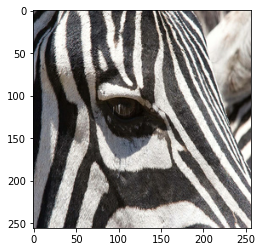

In [4]:
# 随便传一张图片看看效果
inp = load(PATH+'trainB/n02391049_4.jpg')
#  因为 load（） 方法把图片转换成为 float32 格式，所以除以255变成0-1范围内，才可以显示图片
plt.figure()         # 创建1块画布，大小是默认的 figsize=(4,4)
plt.imshow(inp/255)  # plt.imshow()函数负责对图像进行处理,并显示其格式,但不显示图像。其后跟着plt.show()才能显示图像。只有Jupyter默认显示图像

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE  = 20        # 24G显存最高可调到 BATCH_SIZE = 23
IMG_WIDTH   = 256
IMG_HEIGHT  = 256

In [6]:
# ①图片调整大小
# 把照片 reshape 成 height x width x 3 形状
def resize(image, height, width):
    
    # 改变图片的高 宽，通道数保持不变，如果图片是缩小效果，则按照比例缩小；如果图片是变大效果，则最近邻填充
    image = tf.image.resize(image, [height, width],  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return image

# 试试效果
# inp = resize(inp,286,286)
# print(inp.shape)

In [7]:
# ②图片随机裁剪
# 随机裁剪照片为 256 x 256 x 3 大小
def random_crop(image): 
    
    # 在Pix2pix模型中，因为需要把2张图片先摞起来，会造成升维。本模型中不用摞图片，故而没有升维、降维烦恼，比较简单。
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])     
    # cropped_image.shape=( 256, 256, 3),如果图片是通道是1,则会报错 assertion failed，需要把该数据集中通道为1的图片删除出数据集
    return cropped_image    

# 试试效果
# inp_rc = random_crop(inp)
# print(inp_rc.shape)                    #(256, 256, 3)
# print(inp_rc)
# plt.figure()
# plt.imshow(inp_rc/255)

In [8]:
# 把①、②两个小方法归合成1个大方法 + 随机镜面翻转 (调整大小、随机裁剪、随机镜面翻转)
@tf.function()                                 # 此装饰器修饰的函数，只能包含tf语句和简单的python语句，下面的函数是100%全用tf实现
def random_jitter(image):   # 抖动图像，改变图片的形状，数据增强
    
    image = resize(image, 286, 286)    # 改变大小为 286 x 286 x 3
    image = random_crop(image)         # 随机裁剪为 256 x 256 x 3
    
    if tf.random.uniform(()) > 0.5:    # 从均匀分布中输出随机值。生成的值在该 [minval, maxval) 范围内遵循均匀分布.下限 minval 包含在范围内,而上限 maxval 被排除在外。对于浮点数,默认范围是 [0, 1)。
        # 随机镜面翻转
        image = tf.image.flip_left_right(image)
        
    return image   

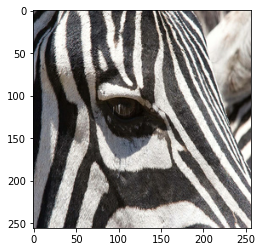

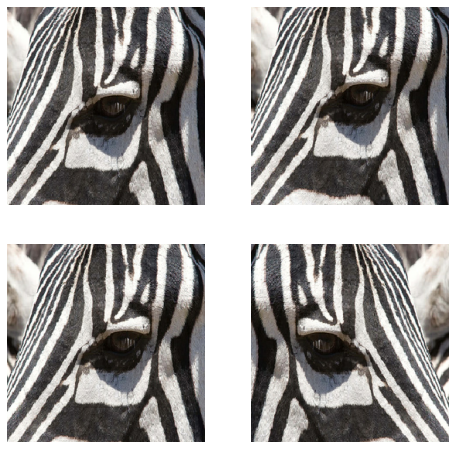

In [9]:
"""
正如您在下图中所看到的，它们正在经历随机抖动，随机抖动是为了

1,将图像调整为更大的高度和宽度
2,随机裁剪为目标大小
3,水平随机翻转图像
"""
# 显示一张图片 看看效果
plt.figure(figsize=(4,4))    # 创建1块画布，大小是（4，4）
plt.imshow(inp/255)          # 原图画出来看看
plt.show()

plt.figure(figsize=(8,8))                         
for i in range(4):                               # 共4次 random_jitter，每次resize效果相同，裁剪和镜像效果不同
    inp_rj = random_jitter(inp)                  # 同一个inp 喂入4次random_jitter，会有4种不同的效果
    plt.subplot(2, 2, i+1)                       # 每次 random_jitter 后，在第 i+1 个子画布上画出来
    plt.imshow(inp_rj/255)
    plt.axis('off')
plt.show()

In [10]:
# 图片（每个像素点数值的范围）标准化到【-1,1】
def normalize(image): 
    
    image = (image/127.5) - 1     # ( image-127.5) /127.5；2种标准化的方法，其实是一样的
    
    return image

# inp_n = normalize(inp)
# print( inp_n.shape )           #(256, 256, 3) 
# print( inp_n )                 #每个像素点数值的范围 已 标准化到【-1,1】

In [11]:
# 定义 训练集的处理方法与规则
def load_image_train(image_path):
    image = load(image_path)
    image = random_jitter(image)
    image = normalize(image)
    
    return image

In [12]:
# 定义 测试集的处理方法与规则
def load_image_test(image_path):
    image = load(image_path)
    # random_jitter 包含：调整大小、随机裁剪、随机镜面翻转，这里只需要 调整大小，所以不用 random_jitter 用 resize
    image = resize(image, IMG_HEIGHT, IMG_WIDTH)    
    image = normalize(image)
    
    return image

(1, 256, 256, 3)
(256, 256, 3)


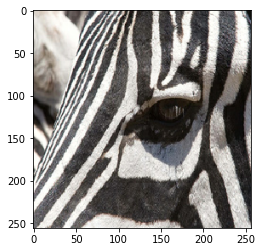

In [13]:
# 随便传一张图片 整体走一遍 看看效果
a = tf.data.Dataset.list_files(PATH+'trainB/n02391049_4.jpg')
a = a.map(load_image_train)            # .map()方法只能适用于tf创建的数据集，不能用于 列表、字符串等
a = a.batch(BATCH_SIZE)                # a的维度是【 bs 256 256 3】共4维

for inp in a:                      
    
    print(inp.shape)                    # inp原本的shape
    inp = ( inp[0,...]/2 ) + 0.5       # 用inp[0,...]砍掉bs所在的维度，再把数值范围从【-1，1】拉回到【0，1】
    print(inp.shape)
    
    plt.figure(figsize=(4,4))    
    plt.imshow(inp)          
    plt.show()

In [14]:
# 制作训练集成品(马与斑马各1个训练集，共2个训练集)
# .map()：train_dataset_horses 内每一个路径都 按照 load_image_train 规则操作一次
# num_parallel_calls 并行调用的电脑核心数,用于提升速度，节省时间。此电脑是6核12线程
# .cache()方法：当计算缓存空间足够时，将预处理的数据存储在缓存空间中将大幅提高计算速度。
train_dataset_horses = train_dataset_horses.map(load_image_train, num_parallel_calls=6).cache().shuffle(BUFFER_SIZE) 
train_dataset_horses = train_dataset_horses.batch(BATCH_SIZE).prefetch(buffer_size=BATCH_SIZE)  #train_ds_horses是 1067/bs 个[bs 256 256 3]的集合

train_dataset_zebras = train_dataset_zebras.map(load_image_train, num_parallel_calls=6).cache().shuffle(BUFFER_SIZE)
train_dataset_zebras = train_dataset_zebras.batch(BATCH_SIZE).prefetch(buffer_size=BATCH_SIZE)  #train_ds_zebras是 1327/bs 个[bs 256 256 3]的集合

In [15]:
# # 检查一下训练集中有没有通道为1的黑白图片，找到并删除出数据集，否则train_dataset_zebras不可用，会一直报错。此段代码需要多跑几遍，直到不再报错
# train_dataset_zebras = tf.data.Dataset.list_files(PATH+'trainB/*.jpg')
# for n,a in train_dataset_zebras.enumerate():
#     print(n)
#     print(a)     # 如果报错，a 就是要删除的图片名字，在数据集中找到 a ，删除出数据集即可
#     image = load_image_train(a)
#     plt.imshow(image)
#     plt.show()

In [16]:
# for image in train_dataset_horses:
#     print(image.shape)
# for i in train_dataset_horses:
#     print(tf.shape(i)[:])
# print(len(train_dataset_horses))

In [17]:
# 制作测试集成品(马与斑马各1个训练集，共2个测试集)
test_dataset_horses  = test_dataset_horses.map(load_image_test, num_parallel_calls=6).cache().batch(BATCH_SIZE)
test_dataset_zebras  = test_dataset_zebras.map(load_image_test, num_parallel_calls=6).cache().batch(BATCH_SIZE)   # 本笔记中这一行其实没有用到

(20, 256, 256, 3)


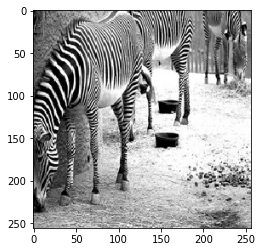

In [18]:
# 从训练集中随便拿一张图片,整体走一遍，看看效果
inp_zebra = next(iter(train_dataset_zebras))
inp_horse = next(iter(train_dataset_horses))
print(inp_zebra.shape)

plt.figure(figsize=(4,4)) 
plt.imshow( ( inp_zebra[0]/2 ) + 0.5)     # inp_horse[0] 与 inp_horse[0,...] 效果一样,拿出第0维的第0个样本（不是拿出数值）
plt.show()

# 生成器 与 判别器
本教程中使用模型体系结构与 pix2pix 中所使用的非常相似。一些区别在于：<br>
Cyclegan 使用 instance normalization（实例归一化）而不是 batch normalization （批归一化）。<br>
CycleGAN 论文使用一种基于 resnet 的改进生成器。简单起见，本教程使用的是改进的 unet 生成器。<br>

生成器的体系结构是经过修改的U-Net。<br>
编码器中的每个块是（Conv-> Batchnorm-> Leaky ReLU）<br>
解码器中的每个块都是（Transposed Conv -> Batchnorm-> Dropout（应用于前三个块）-> ReLU）<br>
编码器和解码器之间存在跳连（如在U-Net中）。<br>

本模型需要：<br>
用 同一个生成器模型 实例化创建 2个生成器：G_马 与 G_斑马<br>
用 同一个判别器模型 实例化创建 2个判别器：D_马 与 D_斑马<br>

生成器 G_斑马  学习将图片   real_马   转换为 gen_斑马。<br>
生成器 G_马   学习将图片   real_斑马  转换为 gen_马。<br>

判别器 D_马   学习区分图片  real_马   与  gen_马。<br>
判别器 D_斑马  学习区分图片  real_斑马  与  gen_斑马。<br>

2个判别器都：输入生成的图像（生成器的输出），应将其分类为伪造的。输入真实的图像，应将其分类为真实的。<br>

In [19]:
import tensorflow_addons as tfa

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
# 定义 编码器中的每个块  （ Conv -> InstanceNorm -> Leaky ReLU ）
def downsample(filters, size, apply_insnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add( tf.keras.layers.Conv2D( filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False) )
    
    if apply_insnorm:
        result.add( tfa.layers.InstanceNormalization() )
        
    result.add( tf.keras.layers.LeakyReLU() )
    
    return result

In [22]:
# 走一张图片看看 编码器 效果
print(inp_zebra[0,...].shape)        # inp_zebra[0,...]拿出第0维的第0个元素(不是数值)，有降维效果，把第0维降掉
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp_zebra[0,...], 0))    # 升维，在第0维度 增加1个维度，数值是1    相当于：inp[tf.newaxis,:,:,:]
print(down_result.shape)   

(256, 256, 3)
(1, 128, 128, 3)


In [23]:
 # 定义 解码器中的每个块 （ Transposed Conv -> InstanceNorm -> Dropout（应用于前三个块）-> ReLU ）
def upsample( filters, size, apply_dropout=False ):
    initializer = tf.random_normal_initializer( 0., 0.02 )

    result = tf.keras.Sequential()
    result.add( tf.keras.layers.Conv2DTranspose( filters, size, strides=2, padding='same',
                                                 kernel_initializer=initializer, use_bias=False) )
    result.add( tfa.layers.InstanceNormalization() )

    if apply_dropout:
        result.add( tf.keras.layers.Dropout(0.5) )

    result.add( tf.keras.layers.ReLU() )

    return result

In [24]:
# 走一张图片看看 解码器 效果
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [25]:
def Generator():    # 生成器生成的是一批次图片  bs 256 256 3
    inputs = tf.keras.layers.Input(shape=[256,256,3])        # 占位，代表输入图片。给输入图片留个坑，并告诉模型输入图片的形状是 256 256 3
    
    down_stack = [
        downsample(64, 4, apply_insnorm=False),    # bs 128,128,64
        downsample(128, 4),    # bs 64, 64, 128
        downsample(256, 4),    # bs 32, 32, 256    
        downsample(512, 4),    # bs 16, 16, 512
        downsample(512, 4),    # bs 8,  8,  512
        downsample(512, 4),    # bs 4,  4,  512
        downsample(512, 4),    # bs 2,  2,  512
        downsample(512, 4)     # bs 1,  1,  512
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),    # bs 2, 2, 1024     与 dowm_stack 拼接后，最终是1024
        upsample(512, 4, apply_dropout=True),    # bs 4, 4, 1024
        upsample(512, 4, apply_dropout=True),    # bs 8, 8, 1024
        upsample(512, 4),    # bs 16, 16, 1024
        upsample(256, 4),    # bs 32, 32, 512
        upsample(128, 4),    # bs 64, 64, 256
        upsample( 64, 4)     # bs 128, 128, 128
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')    # bs 256, 256, 3
    
    x = inputs
    
    # 编码。因为要跳连，故 需要把卷积后的每一张图片都拿到
    skips = []                      # 一张张卷积后的图片的集合   
    for down in down_stack:
        x = down(x)                 # x是一张张卷积后的图片
        skips.append(x)            
    skips = reversed(skips[:-1])    # 逆序，且 skips 中最后一个 即 1， 1，1,512 图片取不到，不要这张
    
    # 解码与建立跳连
    for up, skip in zip(up_stack, skips):     # up_stack, skips，都是列表且都有7个元素
        x = up(x)     # 这时，x 还上一层的结尾的x，还在内存中
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)    
    
    return tf.keras.Model(inputs=inputs, outputs=x)    # 两种实例化方式：①从输入和输出创建模型(模型是函数)，②通过继承Model类(模型是类)

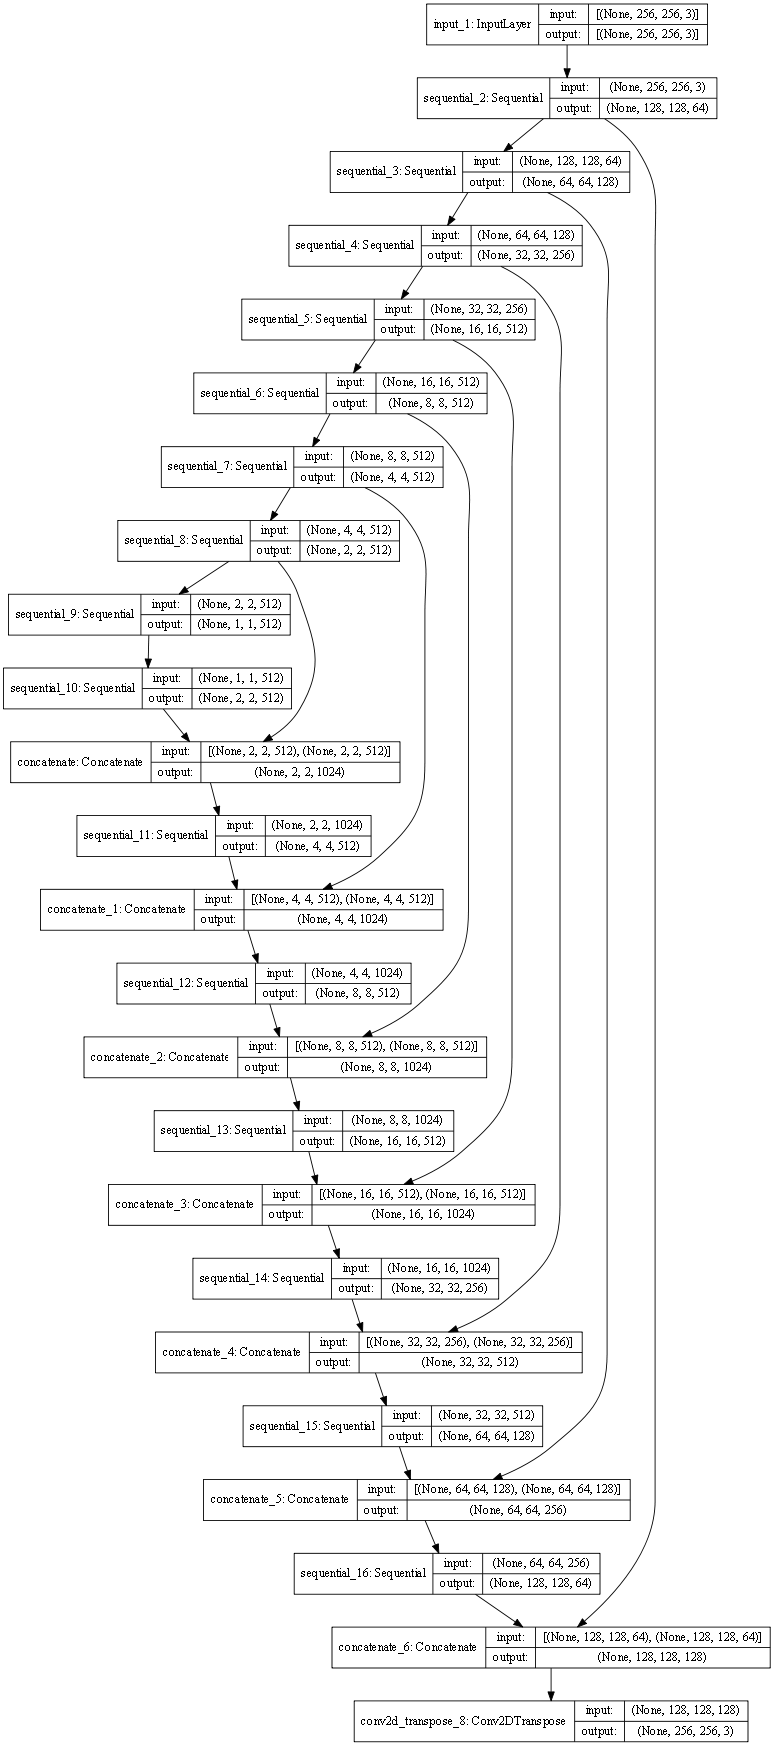

In [26]:
# 可视化 看看生成器啥样子
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [52]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  131328      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  524800      sequential_3[0][0]               
______________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


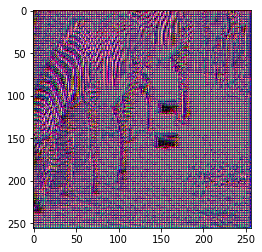

In [28]:
# 效果测试 A ：走一张图片 看看 生成器效果
inp_1 = (inp_zebra[0]+1)*127.5      #把inp的范围从[-1,1]拉回到[0，255]。由于生成器没有训练过，如果inp范围是[-1,1],则会生成一张黑色图片
gen_output = generator(inp_1[tf.newaxis,...], training=False)    # 升维。给 inp_1 增加1个维度,默认是第0维。这里的inp_1像素范围是[0，255]
print(gen_output.shape)           # generator里有归一化，故显示图片时不用归一化了
plt.imshow(gen_output[0,...])     #  降维，砍掉第0个维度

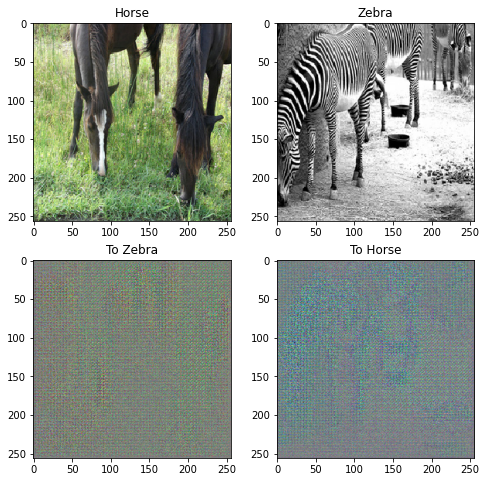

In [29]:
# 效果测试 B ：创建2个生成器，并分别各传入1批次图片，整体走一遍，看看生成器们的效果
generator_zebra = Generator()
generator_horse = Generator()
to_zebra = generator_zebra(inp_horse, training=False)       # inp_horse 的 shape [ bs, 256, 256, 3 ]
to_horse = generator_horse(inp_zebra, training=False)       # inp_zebra 的 shape [ bs, 256, 256, 3 ]

img   = [inp_horse, inp_zebra, to_zebra, to_horse]    
title = ['Horse', 'Zebra', 'To Zebra', 'To Horse']

plt.figure( figsize=(8, 8) )
for i in range(4):
    plt.subplot( 2, 2, i+1 )
    plt.title(title[i])
    plt.imshow(img[i][0] * 0.5 + 0.5) 
plt.show()

# 建立判别器
判别器是PatchGAN。<br>
判别器中的每个块是（Conv-> BatchNorm-> Leaky ReLU）<br>
最后一层之后的输出形状为（batch_size，30，30，1）<br>
输出的每个30x30色块对输入图像的70x70部分进行分类（这种架构称为PatchGAN）。<br>
判别器应当：输入生成图像，应将其分类为伪造的。输入真实的图像，应将其分类为真实的。

In [30]:
def Discriminator():    # 判别器输出的是一张 图片， bs 30 30 1
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[256,256,3], name='input_image')
#     tar = tf.keras.layers.Input(shape=[256,256,3], name='target_image')
    
#     x = tf.keras.layers.concatenate([inp, tar])    # bs, 256, 256, channels*2
    
    down1 = downsample(64, 4, False)(inp)    # bs, 128, 128, 64
    down2 = downsample(128, 4)(down1)       # bs, 64, 64, 128
    down3 = downsample(256, 4)(down2)       # bs, 32, 32, 256
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)    # bs, 34, 34, 256
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # 没padding，bs,31,31,512
    
    insnorm1   = tfa.layers.InstanceNormalization()(conv) 
    leaky_relu = tf.keras.layers.LeakyReLU()(insnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)    # bs, 33, 33, 512  
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)    # bs, 30, 30, 1
    
    return tf.keras.Model(inputs=inp, outputs=last)

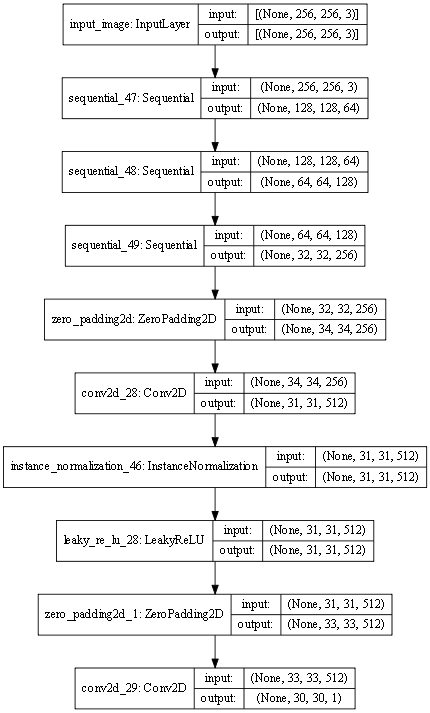

In [31]:
# 可视化 看看判别器啥样子
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [32]:
# discriminator.summary()

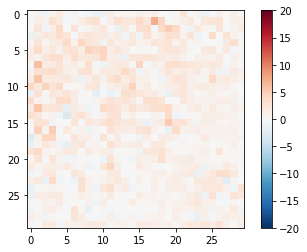

In [33]:
# 效果测试 C ：走一张图片 看看 判别器效果（将 效果测试A 的生成结果输入这里）
disc_out = discriminator(gen_output, training=False)     # 判别器输出的是一张 图片， bs 30 30 1
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')    # 切掉第0维度 和 最后1个维度
plt.colorbar()

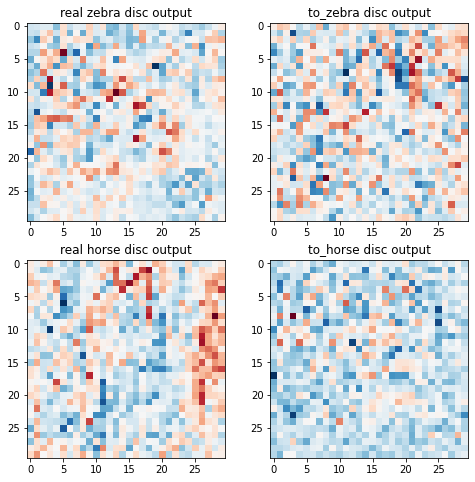

In [34]:
# 效果测试 D ：创建2个判别器，并分别各传入1批次图片，整体走一遍，看看判别器们的效果
discriminator_zebra = Discriminator()
discriminator_horse = Discriminator()

plt.figure( figsize=(8,8) )

plt.subplot(2,2,1)
plt.title('real zebra disc output')
plt.imshow(discriminator_zebra(inp_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(2,2,2)
plt.title('to_zebra disc output')
plt.imshow(discriminator_zebra(to_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(2,2,3)
plt.title('real horse disc output')
plt.imshow(discriminator_zebra(inp_horse)[0, ..., -1], cmap='RdBu_r')

plt.subplot(2,2,4)
plt.title('to_horse disc output')
plt.imshow(discriminator_zebra(to_horse)[0, ..., -1], cmap='RdBu_r')

# Loss


In [35]:
LAMBDA = 10

In [36]:
# BCE：二分类；  CE：多分类
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)     # from_logits=True 算出来的值 要不要 概率化

In [37]:
# 喂入 与 生成过程：

# 马    → 斑马生成器  → gen_斑马， gen_斑马  → 马生成器    → cycled_马 
# 斑马  → 马生成器    → gen_马  ， gen_马    → 斑马生成器  → cycled_斑马  

# 马    → 马生成器    → self_马
# 斑马  → 斑马生成器  → self_斑马

# 斑马生成器，马生成器                      ：分别都用 generator_loss
# (马，cycled_马)  与 (斑马，cycled_斑马 )  ：分别都用 cycle_loss
# (马，self_马  )  与 (斑马，self_斑马   )  ：分别都用 self_loss

In [38]:
# 生成器对抗loss：这里我们将把 判别器在生成图片上的判断结果 与一个值全为 1 的数组进行对比。
def generator_loss(disc_generated_output):    # disc_generated_output：生成图判断结果
    gen_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output) 
    return gen_loss

# 判别器对抗loss：
# 将 判别器对 真实 图片的判断结果 与 值全为 1 的数组 进行对比，
# 将 判别器对 生成 图片的判断结果 与 值全为 0 的数组 进行对比。
def discriminator_loss(disc_real_output, disc_generated_output):
    
    disc_real_loss       = cross_entropy(tf.ones_like(disc_real_output),  disc_real_output) 
    disc_generated_loss  = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output) 
    
    disc_loss = ( disc_real_loss + disc_generated_loss ) * 0.5
    
    return disc_loss

# 循环一致性loss：
def cycle_loss(real_image, cycled_image):                          # cycled_image：马 → gen_斑马 → cycled_马 
    cycle_loss = tf.reduce_mean( tf.abs(real_image - cycled_image) )       # 真图 与 cycled_图 的 L1 损失
    return LAMBDA * cycle_loss

# 自身一致性loss：               （self_image： 马 → 马生成器 → self_马， 生成的马（self_image）应该是不变的。斑马的同理
def self_loss(real_image, self_image):     
    self_loss  = tf.reduce_mean( tf.abs(real_image - self_image) )          # 真图 与 self_图 的 L1 损失
    return LAMBDA * 0.5 * self_loss

# 定义优化器和Checkpoint-saver

In [39]:
# 由于我们需要分别训练4个网络，故每个网络需要创建1个优化器，共4个优化器。
generator_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)     # beta_1: float，0<beta<1。一般接近1。一阶矩估计的指数衰减率。
generator_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
checkpoint_dir = 'F:\App\work\check_point\CycleGan'
# 2个生成器，2个判别器，4个优化器，共8个
checkpoint = tf.train.Checkpoint(generator_zebra=generator_zebra,
                                 generator_horse=generator_horse,
                                 discriminator_zebra=discriminator_zebra,
                                 discriminator_horse=discriminator_horse,
                                 generator_zebra_optimizer=generator_zebra_optimizer,
                                 generator_horse_optimizer=generator_horse_optimizer,
                                 discriminator_zebra_optimizer=discriminator_zebra_optimizer,
                                 discriminator_horse_optimizer=discriminator_horse_optimizer )

# 在长时间的训练后，程序会保存大量的 Checkpoint，但我们只想保留最后的几个 Checkpoint,使用 CheckpointManager
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, checkpoint_name='model.ckpt', max_to_keep=5)

# 如果存在检查点，则恢复最新的检查点
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('最近的检查点已经恢复!!')

最近的检查点已经恢复!!


# 产生影像
在训练过程中绘制一些图像。<br>

我们将图像从测试数据集中传递到生成器。<br>
然后，生成器将输入图像转换为输出。<br>
最后一步是绘制预测，瞧！

In [41]:
def show_images(model, test_input):        # test_input的shape是 bs 256 256 3
    generated_image = model(test_input, training=True)
    
    display_list = [ test_input[0], generated_image[0] ]     # test_input[0]拿出第0维的第0个元素(不是数值)，有降维效果，把第0维降掉
    title = [ 'Input Image', 'Generated Image' ]
    
    plt.figure(figsize=(8, 8))
    for i in range(2):
        plt.subplot(1, 2, i+1)                        # 用第 i+1 个子区域
        plt.title(title[i])                           # 用第 i 个 title
        plt.imshow(display_list[i] * 0.5 + 0.5)       # 把第 i 个图像显示出来。把像素值归一化到【0，1】范围，以便显示图像画面.
        plt.axis('off')
    plt.show()

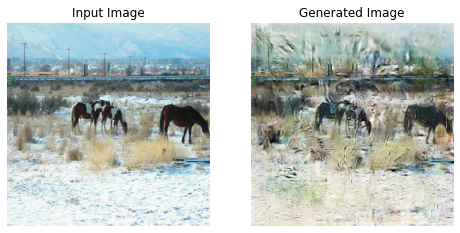

In [42]:
# 从测试集中 随机 拿出一个看看效果
for example_input in test_dataset_horses.take(1):  # .take(1)使test_ds_horses降低1维，从第0维中随机拿出1个样本，第0维被降掉
    show_images(generator_zebra, example_input)    # example_input的 shape是 (bs, 256, 256, 3)。test_ds_horses是 120/bs个[bs 256 256 3]的集合

In [43]:
# for example_input in test_dataset_horses.take(1):  
#     print(example_input.shape)                       # (bs, 256, 256, 3)
#     print(example_input[0].shape)                    # (256, 256, 3)

# 训练
训练循环看起来复杂，但它包含五个基本步骤:<br>
①得到预测。<br>
②计算loss。<br>
③计算梯度用反向传播。<br>
④将梯度应用于优化器。<br>
⑤将损失记录到TensorBoard。

In [44]:
EPOCHS = 400

In [45]:
import datetime
log_path = "F:\\App\\work\\check_point\\CycleGan\\logsfit_1111\\"
# log_dir  = log_path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer( log_path )    # 创建监控对象，并制定监控数据的写入目录

In [46]:
def train_step(real_horse, real_zebra, epoch):   
    # persistent被设置为True，因为tape被多次使用，来计算梯度。直观的讲，tape 记录的是 生成动作、判别动作、loss（其实记录的就是 前向传播）
    with tf.GradientTape(persistent=True) as tape:
        
        # 6个生成结果（生成器_马需要喂入3类图：real_斑马、gen_斑马、real_马；生成器_斑马也需要喂入3类图：real_马、gen_马、real_斑马）
        gen_zebra    = generator_zebra(real_horse, training=True)  #马   → 斑马生成器 → gen_斑马， gen_斑马 → 马生成器   → cycled_马 
        cycled_horse = generator_horse(gen_zebra,  training=True)        
         
        gen_horse    = generator_horse(real_zebra, training=True)  #斑马 → 马生成器   → gen_马  ， gen_马   → 斑马生成器 → cycled_斑马
        cycled_zebra = generator_zebra(gen_horse,  training=True)  
        
        self_horse   = generator_horse(real_horse, training=True)  #马   → 马生成器   → self_马 ， 斑马     → 斑马生成器 → self_斑马
        self_zebra   = generator_zebra(real_zebra, training=True)
        
        # 4个判别结果（往2个生判别中输入不同的图片，产生的结果）
        disc_real_horse_output = discriminator_horse(real_horse, training=True)  # real_马   传进 disc_马   产生的判别结果
        disc_real_zebra_output = discriminator_zebra(real_zebra, training=True)  # real_斑马 传进 disc_斑马 产生的判别结果
        
        disc_generated_horse_output = discriminator_horse(gen_horse, training=True)  # gen_马   传进 disc_马   产生的判别结果
        disc_generated_zebra_output = discriminator_zebra(gen_zebra, training=True)  # gen_斑马 传进 disc_斑马 产生的判别结果
        
        # 计算loss
        generator_zebra_loss = generator_loss(disc_generated_zebra_output)
        generator_horse_loss = generator_loss(disc_generated_horse_output)
        
        total_cycle_loss = cycle_loss(real_horse, cycled_horse) + cycle_loss(real_zebra, cycled_zebra)
        
        # 4个网络各自的loss（生成器loss = 对抗loss + cycle_loss + self_loss）
        total_generator_zebra_loss = generator_zebra_loss + total_cycle_loss + self_loss(real_zebra, self_zebra)
        total_generator_horse_loss = generator_horse_loss + total_cycle_loss + self_loss(real_horse, self_horse)
        
        disc_horse_loss = discriminator_loss(disc_real_horse_output, disc_generated_horse_output)
        disc_zebra_loss = discriminator_loss(disc_real_zebra_output, disc_generated_zebra_output)
        
    # 4个网络各自的梯度（用 tape 记录的 loss 算梯度）
    generator_zebra_gradients = tape.gradient(total_generator_zebra_loss, generator_zebra.trainable_variables)
    generator_horse_gradients = tape.gradient(total_generator_horse_loss, generator_horse.trainable_variables)
    
    discriminator_horse_gradients = tape.gradient(disc_horse_loss, discriminator_horse.trainable_variables)
    discriminator_zebra_gradients = tape.gradient(disc_zebra_loss, discriminator_zebra.trainable_variables)
    
    # 4个网络各自的优化器（将梯度应用于优化器（其实就是反向传播））
    generator_zebra_optimizer.apply_gradients( zip(generator_zebra_gradients, generator_zebra.trainable_variables) )
    generator_horse_optimizer.apply_gradients( zip(generator_horse_gradients, generator_horse.trainable_variables) )
    
    discriminator_horse_optimizer.apply_gradients(zip(discriminator_horse_gradients, discriminator_horse.trainable_variables))
    discriminator_zebra_optimizer.apply_gradients(zip(discriminator_zebra_gradients, discriminator_zebra.trainable_variables))
    
    with summary_writer.as_default():    # 记录损失函数
        tf.summary.scalar('generator_zebra_loss', generator_zebra_loss, step=epoch)
        tf.summary.scalar('generator_horse_loss', generator_horse_loss, step=epoch)
        tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=epoch)
        tf.summary.scalar('total_generator_zebra_loss', total_generator_zebra_loss, step=epoch)
        tf.summary.scalar('total_generator_horse_loss', total_generator_horse_loss, step=epoch)
        tf.summary.scalar('disc_horse_loss', disc_horse_loss, step=epoch)
        tf.summary.scalar('disc_zebra_loss', disc_zebra_loss, step=epoch)

# 实际的训练循环：
迭代epoch数。<br>
在每个epoch，它将清除显示，并运行show_images以显示进度。<br>
在每个epoch上，它迭代训练数据集，并打印一个“.” 。1个“.”代表1个批次的图片。<br>
每5个epoch保存一个检查点。

In [47]:
def fit(train_ds_horses, train_ds_zebras, epochs, test_ds_horses):
    for epoch in range(epochs):
        start = time.time()
        display.clear_output(wait=True)    # IPython 中的 display 模块 ,清除已显示的图片
        
        # 显示图像，用来查看进度与效果
        for example_input in test_ds_horses.take(1):     
            show_images(generator_zebra, example_input)
        print("Epoch: ", epoch)
        
        # 训练
        # tf.data.Dataset.zip((train_ds_horses, train_ds_zebras))以最少的来确定数量，这里是train_ds_horses的1067张图片
        for n, (horse, zebra) in tf.data.Dataset.zip((train_ds_horses, train_ds_zebras)).enumerate():
            print('.', end='')        # 1个“ . ”代表bs张图片
            if (n+1) % 100 == 0:
                print()   # 换行
            train_step(horse, zebra, epoch) 
        print()           # 换行
        
        # 每 5 个 epoch 保存一次模型参数
        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('已训练完 {} 个 epoch ，保存的模型参数文件是 {}'.format(epoch+1, ckpt_save_path))
        
        # 打印本次 epoch 消耗的时间  
        print ('第 {} 个 epoch 训练消耗时间 {} 秒\n'.format(epoch + 1, time.time()-start))
    
#     # 训练结束，最后再保存一次模型参数
#     ckpt_save_path = ckpt_manager.save()
#     print ('已训练完最后一个 epoch {} ，保存的模型参数文件是 {}'.format(epoch+1, ckpt_save_path))

In [48]:
%reload_ext tensorboard
%tensorboard --logdir=log_path

Reusing TensorBoard on port 6006 (pid 8420), started 0:00:37 ago. (Use '!kill 8420' to kill it.)

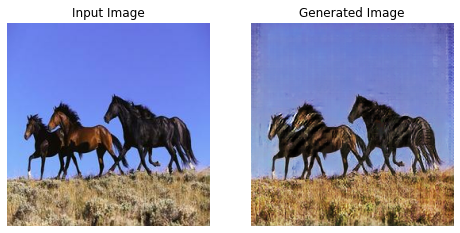

Epoch:  5
.......

KeyboardInterrupt: 

In [49]:
%%time
fit(train_dataset_horses, train_dataset_zebras, EPOCHS, test_dataset_horses)     # train_dataset用来训练；test_dataset用来看训练效果

In [50]:
display.IFrame(
    src="http://localhost:6006/",
    width="100%",
    height="1000px")